In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
data_dir = 'TSLA.csv'
df = pd.read_csv(data_dir, parse_dates= True , index_col= "Date")

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


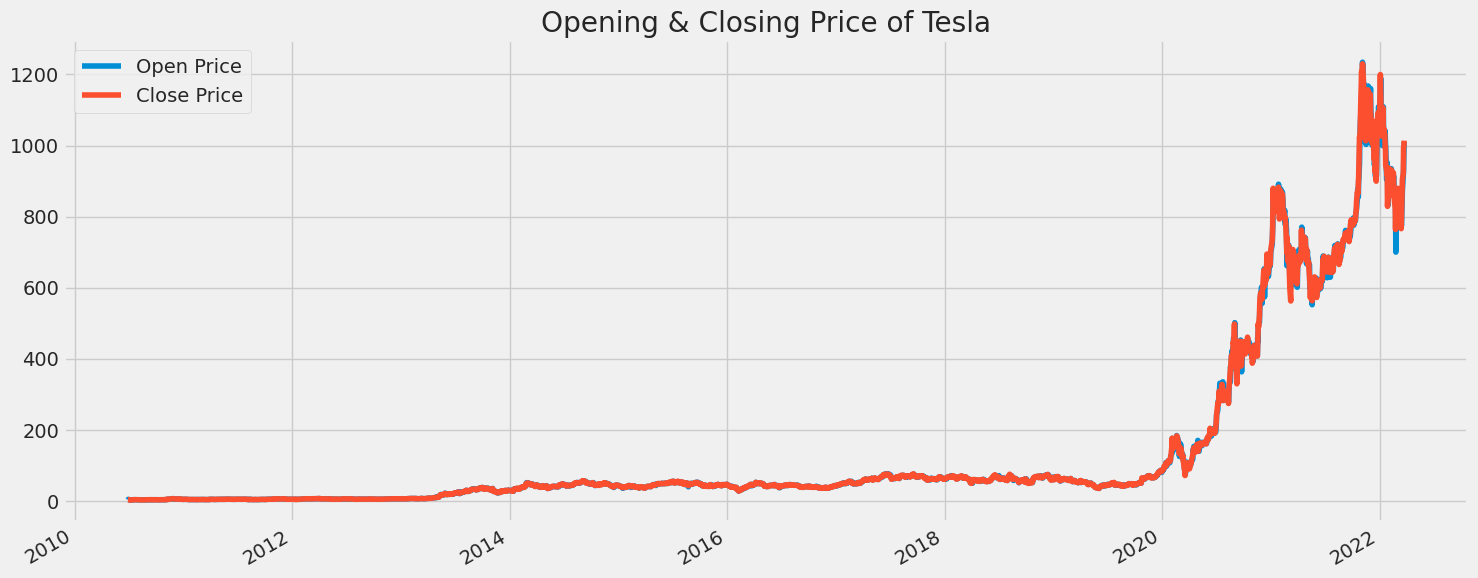

In [ ]:
plt.figure(figsize=(15, 6))
df['Open'].plot()
df['Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price of Tesla")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

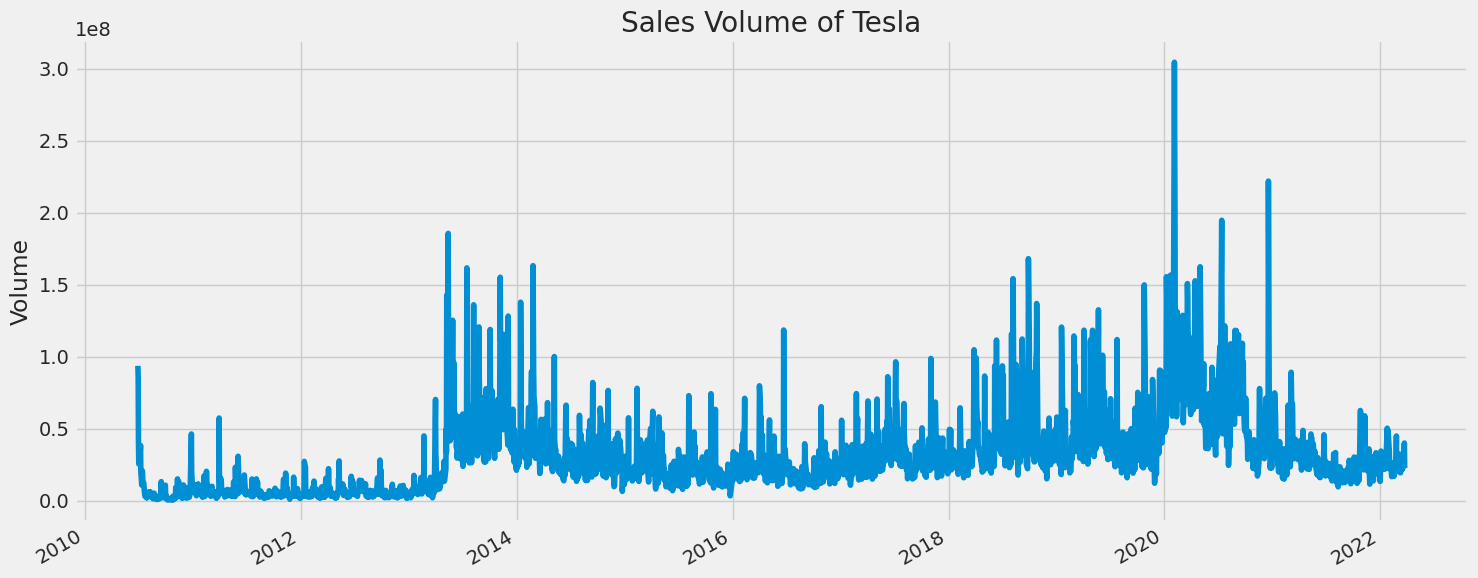

In [ ]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume of Tesla")
plt.tight_layout()
plt.show()

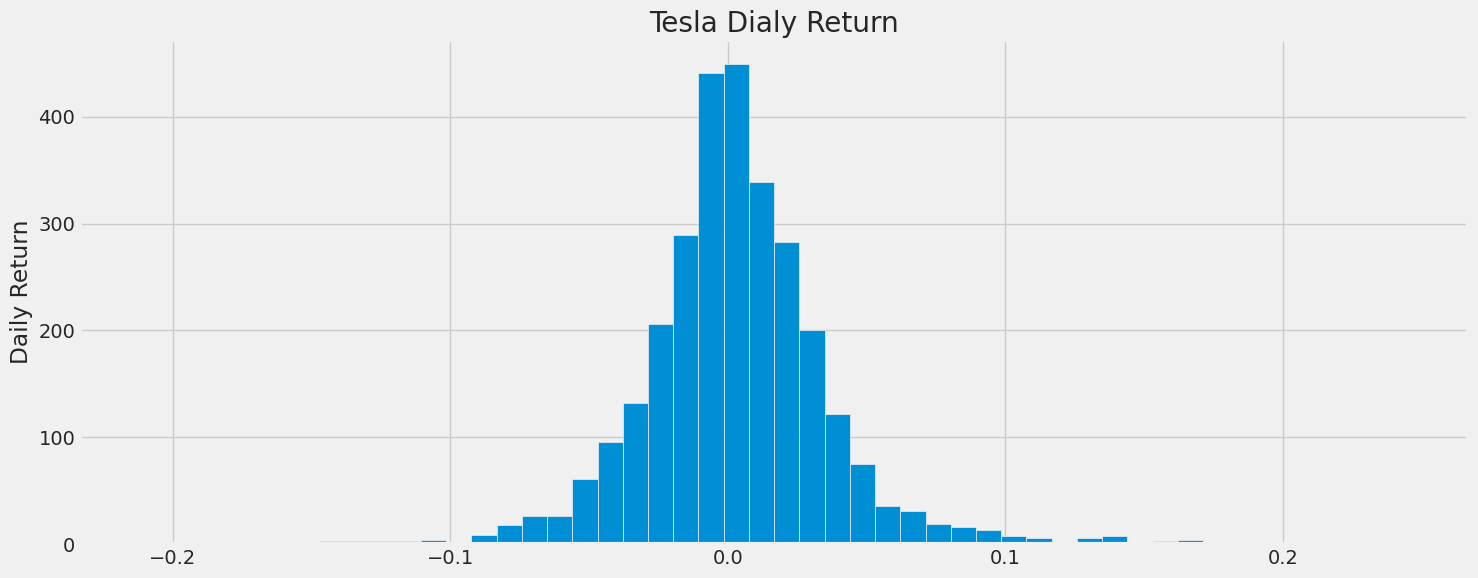

In [ ]:
# We'll use pct_change to find the percent change for each day
plt.figure(figsize=(15, 6))
df['Adj Close'].pct_change().hist(bins=50)
plt.ylabel('Daily Return')
plt.title(f'Tesla Dialy Return')
plt.tight_layout()
plt.show()

In [ ]:
dataset = df["Close"]
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(2956, 1)

In [ ]:
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [ ]:
train_size = int(len(data)*.75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

Train Size : 2217 Test Size : 739


In [ ]:
train_data.shape, test_data.shape

((2217, 1), (799, 1))

In [ ]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
x_train.shape , y_train.shape

((2157, 60, 1), (2157,))

In [ ]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.6624e-04 - mean_absolute_error: 0.0084
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0039e-06 - mean_absolute_error: 0.0016
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5441e-06 - mean_absolute_error: 0.0017
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5963e-06 - mean_absolute_error: 0.0016
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6349e-06 - mean_absolute_error: 0.0015
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3068e-06 - mean_absolute_error: 0.0017
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.3178e-06 - mean_absolute_error: 0.0017
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.3208e-06 - mean_absolute_error: 0.0017
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.8112e-06 - mean_absolute_error: 0.0017
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8046e-06 - mean_absolute_error: 0.00

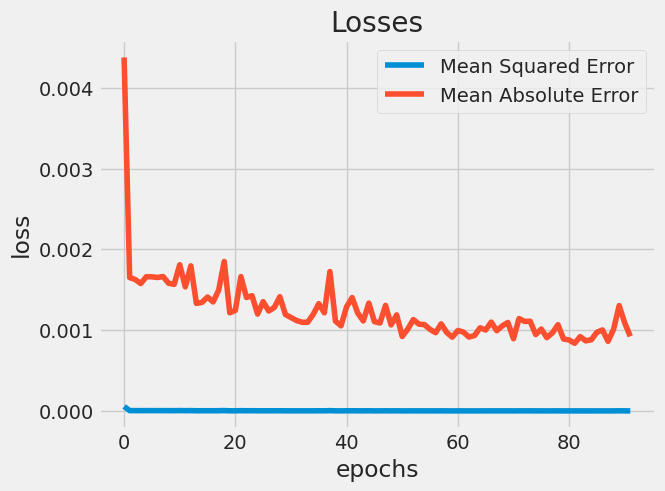

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_test.shape , y_test.shape

((739, 60, 1), (739,))

In [ ]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


(739, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

22.38

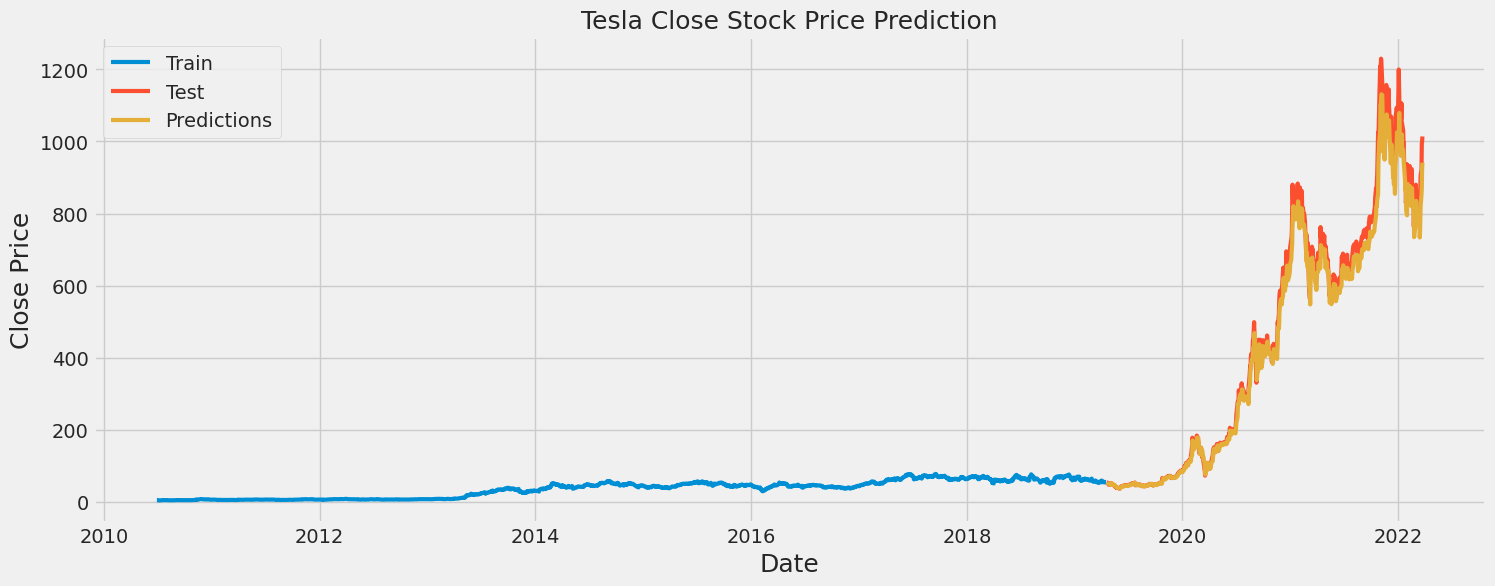

In [ ]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Tesla Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

In [ ]:
from datetime import timedelta

In [ ]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [ ]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0])
    print(forcast)
    Xin = insert_end(Xin, out[0, 0])
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[0.7645643]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.7645643, 0.733224]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.7645643, 0.733224, 0.69647425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.7645643, 0.733224, 0.69647425, 0.6595714]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.7645643, 0.733224, 0.69647425, 0.6595714, 0.6245354]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.7645643, 0.733224, 0.69647425, 0.6595714, 0.6245354, 0.5924627]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.7645643, 0.733224, 0.69647425, 0.6595714, 0.6245354, 0.5924627, 0.56384474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[0.7645643, 0.733224, 0.69647425, 0.6595714, 0.6245354, 0.5924627, 0.56384474, 0.5387469]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[0.7645643, 0.733224, 0.69647425, 0.6595714, 0.6245354, 0.5924627, 0.56384474, 0.5387469, 0.51695496]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.7645643, 0.733224, 0.69647425, 0.6595714, 0.6245354, 0.5924627, 0.56384474, 0.5387469, 0.51695496, 0.49809155]

In [ ]:
time

[Timestamp('2022-03-24 00:00:00'),
 Timestamp('2022-03-25 00:00:00'),
 Timestamp('2022-03-26 00:00:00'),
 Timestamp('2022-03-27 00:00:00'),
 Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-03-29 00:00:00'),
 Timestamp('2022-03-30 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-04-02 00:00:00'),
 Timestamp('2022-04-03 00:00:00'),
 Timestamp('2022-04-04 00:00:00'),
 Timestamp('2022-04-05 00:00:00'),
 Timestamp('2022-04-06 00:00:00'),
 Timestamp('2022-04-07 00:00:00'),
 Timestamp('2022-04-08 00:00:00'),
 Timestamp('2022-04-09 00:00:00'),
 Timestamp('2022-04-10 00:00:00'),
 Timestamp('2022-04-11 00:00:00'),
 Timestamp('2022-04-12 00:00:00'),
 Timestamp('2022-04-13 00:00:00'),
 Timestamp('2022-04-14 00:00:00'),
 Timestamp('2022-04-15 00:00:00'),
 Timestamp('2022-04-16 00:00:00'),
 Timestamp('2022-04-17 00:00:00'),
 Timestamp('2022-04-18 00:00:00'),
 Timestamp('2022-04-19 00:00:00'),
 Timestamp('2022-04-20 00:00:00'),
 Timestamp('2022-04-

In [ ]:
forcasted_output = np.asanyarray(forcast)
forcasted_output = forcasted_output.reshape(-1, 1)
forcasted_output = scaler.inverse_transform(forcasted_output)

In [ ]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

In [ ]:
df_result

,Date,Forecasted
0,2022-03-24,941.089294
1,2022-03-25,902.642578
2,2022-03-26,857.559814
3,2022-03-27,812.289246
4,2022-03-28,769.308838
5,2022-03-29,729.963684
6,2022-03-30,694.856567
7,2022-03-31,664.067810
8,2022-04-01,637.334534
9,2022-04-02,614.193787


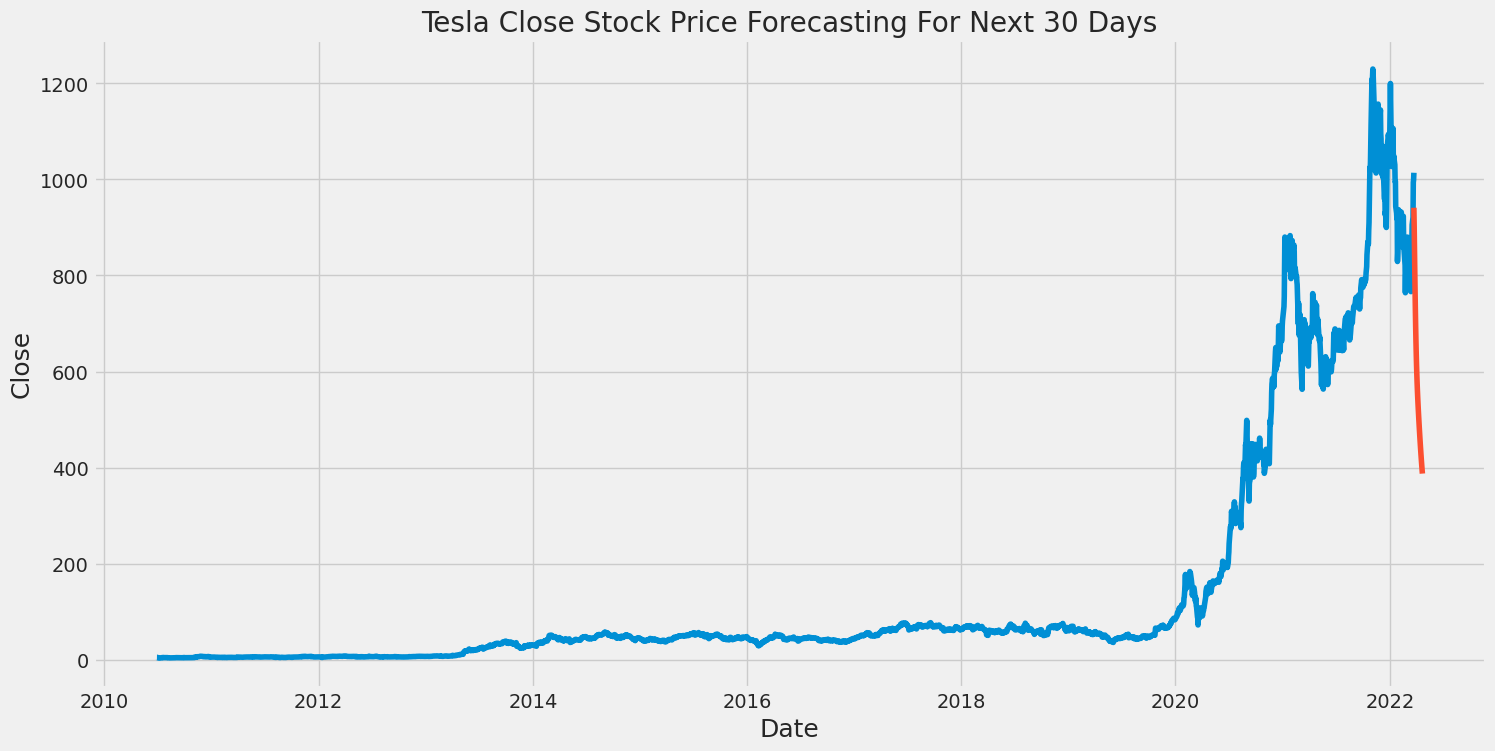

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Tesla Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close' ,fontsize=18)
plt.plot(df['Close'])
plt.plot(df_result.set_index('Date')[['Forecasted']])